In [1]:
import matplotlib.pyplot as plt
import json
import torch
import pickle
from typing import Optional
from matplotlib.colors import Normalize
import numpy as np
import os
import random
import datasets

import einops
import dictionary_learning.interp as interp
from circuitsvis.activations import text_neuron_activations
from collections import namedtuple
from nnsight import LanguageModel
from tqdm import tqdm

import experiments.utils as utils
from dictionary_learning.utils import hf_dataset_to_generator
from dictionary_learning.buffer import ActivationBuffer

DEBUGGING = True

if DEBUGGING:
    tracer_kwargs = dict(scan=True, validate=True)
else:
    tracer_kwargs = dict(scan=False, validate=False)

In [2]:
DEVICE = "cuda"
model_name = "EleutherAI/pythia-70m-deduped"
model = LanguageModel(model_name, device_map=DEVICE, dispatch=True)


context_length = 128

dataset = datasets.load_dataset("NeelNanda/pile-10k", streaming=False)

tokenizer = model.tokenizer

def tokenization(data):
    return tokenizer(data["text"], truncation=True, max_length=context_length, padding="max_length") 

tokenized_dataset = dataset.map(tokenization, batched=True)

encoded_inputs_bL = []

for i in tokenized_dataset["train"]:
    encoded_inputs_bL.append(i["input_ids"])
print(len(encoded_inputs_bL))
print(encoded_inputs_bL[0])

10000
[1147, 310, 2218, 13, 285, 9262, 15, 1422, 476, 1132, 773, 14102, 48527, 273, 253, 308, 505, 10558, 668, 327, 10469, 13, 285, 327, 253, 4384, 15, 50000, 327, 253, 4384, 2987, 13, 533, 368, 452, 281, 26065, 4471, 14, 30713, 323, 2829, 4886, 285, 326, 476, 320, 247, 2372, 21643, 15, 187, 187, 2512, 457, 84, 247, 2257, 309, 457, 69, 751, 281, 2312, 670, 15, 309, 457, 620, 564, 949, 1046, 9400, 13, 978, 264, 273, 2403, 253, 6867, 752, 2427, 987, 16, 36222, 1618, 15, 187, 187, 1773, 916, 187, 187, 32197, 689, 253, 10014, 369, 3164, 581, 273, 253, 31056, 8892, 309, 574, 281, 2454, 15, 187, 187, 32234, 13, 309, 574, 271, 2934, 273, 752, 2238, 273, 2165, 309, 3078, 281, 1287, 13]


In [13]:
import einops
import dictionary_learning.interp as interp
from circuitsvis.activations import text_neuron_activations
from collections import namedtuple
from nnsight import LanguageModel
from tqdm import tqdm

import experiments.utils as utils
from dictionary_learning.utils import hf_dataset_to_generator
from dictionary_learning.buffer import ActivationBuffer


DEBUGGING = True

if DEBUGGING:
    tracer_kwargs = dict(scan=True, validate=True)
else:
    tracer_kwargs = dict(scan=False, validate=False)


def get_max_activating_prompts(
    model,
    submodule,
    inputs_bL: list[list[int]],
    dim_indices: torch.Tensor,
    batch_size: int,
    dictionary=None,
    n_inputs: int = 512,
    k: int = 30,
):

    assert n_inputs % batch_size == 0
    n_iters = n_inputs // batch_size

    feature_count = dim_indices.shape[0]

    device = model.device

    max_activating_indices_FK = torch.zeros((feature_count, k), device=device, dtype=torch.int)
    max_activations_FK = torch.zeros((feature_count, k), device=device, dtype=torch.float32)
    max_tokens_FKL = torch.zeros((feature_count, k, context_length), device=device, dtype=torch.int)
    max_activations_FKL = torch.zeros((feature_count, k, context_length), device=device, dtype=torch.float32)

    for i in tqdm(range(n_iters)):

        batch_offset = i * batch_size

        inputs_BL = torch.tensor(inputs_bL[batch_offset : batch_offset + batch_size], device=device)

        with torch.no_grad(), model.trace(inputs_BL, **tracer_kwargs):
            activations_BLD = submodule.output
            if type(activations_BLD.shape) == tuple:
                activations_BLD = activations_BLD[0]
            activations_BLF = dictionary.encode(activations_BLD)
            activations_BLF = activations_BLF[:, :, dim_indices].save()

        activations_FBL = einops.rearrange(activations_BLF.value, 'B L F -> F B L')
        # Use einops to find the max activation per input
        activations_FB = einops.reduce(activations_FBL, 'F B L -> F B', 'max')
        tokens_FBL = einops.repeat(inputs_BL, 'B L -> F B L', F=feature_count)
        
        # Keep track of input indices
        indices_B = torch.arange(batch_offset, batch_offset + batch_size, device=device)
        indices_FB = einops.repeat(indices_B, 'B -> F B', F=feature_count)

        # Concatenate current batch activations and indices with the previous ones
        combined_activations_FB = torch.cat([max_activations_FK, activations_FB], dim=1)
        combined_indices_FB = torch.cat([max_activating_indices_FK, indices_FB], dim=1)
        combined_activations_FBL = torch.cat([max_activations_FKL, activations_FBL], dim=1)
        combined_tokens_FBL = torch.cat([max_tokens_FKL, tokens_FBL], dim=1)

        # Sort and keep top k activations for each dimension
        topk_activations_FK, topk_indices_FK = torch.topk(combined_activations_FB, k, dim=1)
        max_activations_FK = topk_activations_FK

        feature_indices_F1 = torch.arange(feature_count, device=device)[:, None]
        max_activating_indices_FK = combined_indices_FB[feature_indices_F1, topk_indices_FK]
        max_activations_FKL = combined_activations_FBL[feature_indices_F1, topk_indices_FK]
        max_tokens_FKL = combined_tokens_FBL[feature_indices_F1, topk_indices_FK]
            

    return max_tokens_FKL, max_activations_FKL

dictionaries_path = "../dictionary_learning/dictionaries"

# Current recommended way to generate graphs. You can copy paste ae_sweep_paths directly from bib_intervention.py
ae_sweep_paths = {
    # "pythia70m_sweep_standard_ctx128_0712": {"resid_post_layer_3": {"trainer_ids": [11]}},
    # "pythia70m_sweep_gated_ctx128_0730": {"resid_post_layer_3": {"trainer_ids": [9]}},
    "pythia70m_sweep_topk_ctx128_0730": {"resid_post_layer_3": {"trainer_ids": [2]}},
}
sweep_name = list(ae_sweep_paths.keys())[0]
submodule_trainers = ae_sweep_paths[sweep_name]

filter_class_ids = []
# filter_class_ids = [-4, -2]

ae_group_paths = utils.get_ae_group_paths(dictionaries_path, sweep_name, submodule_trainers)
ae_paths = utils.get_ae_paths(ae_group_paths)

# TODO
# Add bias_in_bios dataset option
# Cosine sim with probes
# Vector per class probe

ae_path = ae_paths[0]
submodule, dictionary, config = utils.load_dictionary(model, ae_path, DEVICE)

node_effects_filename = f"{ae_path}/node_effects.pkl"

with open(node_effects_filename, "rb") as f:
    node_effects = pickle.load(f)

effects = node_effects[-2][ae_path]

print(effects.shape)

k = 500
top_k_values, top_k_indices = torch.topk(effects, k)
torch.set_printoptions(sci_mode=False)
print(top_k_values)
print(top_k_indices)

all_indices = torch.arange(0, effects.shape[0])
all_indices = top_k_indices
torch.cuda.empty_cache()
import gc
gc.collect()
max_tokens_FKL, max_activations_FKL = get_max_activating_prompts(model, submodule, encoded_inputs_bL, all_indices, 250, dictionary, 10000, 30)

Loading dictionary from ../dictionary_learning/dictionaries/pythia70m_sweep_topk_ctx128_0730/resid_post_layer_3/trainer_2/
torch.Size([16384])
tensor([    1.8827,     0.6107,     0.2105,     0.1868,     0.0663,     0.0531,
            0.0387,     0.0272,     0.0244,     0.0201,     0.0191,     0.0163,
            0.0161,     0.0159,     0.0142,     0.0139,     0.0137,     0.0134,
            0.0132,     0.0131,     0.0126,     0.0124,     0.0120,     0.0114,
            0.0104,     0.0104,     0.0101,     0.0099,     0.0097,     0.0094,
            0.0094,     0.0092,     0.0087,     0.0087,     0.0087,     0.0084,
            0.0083,     0.0083,     0.0081,     0.0080,     0.0078,     0.0073,
            0.0059,     0.0057,     0.0056,     0.0051,     0.0051,     0.0048,
            0.0048,     0.0047,     0.0047,     0.0046,     0.0045,     0.0044,
            0.0043,     0.0042,     0.0041,     0.0041,     0.0040,     0.0039,
            0.0038,     0.0038,     0.0037,     0.0037,  

100%|██████████| 40/40 [00:15<00:00,  2.64it/s]


In [14]:
for feat_idx in range(10):
    sae_feat_idx = top_k_indices[feat_idx].item()
    print(f"Feature index: {feat_idx}")
    print(sae_feat_idx)

    encoded_tokens_KL = max_tokens_FKL[feat_idx].tolist()
    activations_KL = max_activations_FKL[feat_idx]

    activations_KL11 = [activations_KL[k, :, None, None] for k in range(activations_KL.shape[0])]
    def _list_decode(x):
        if isinstance(x, int):
            return model.tokenizer.decode(x)
        else:
            return [_list_decode(y) for y in x]

    decoded_tokens_KL = _list_decode(encoded_tokens_KL)
    top_contexts = text_neuron_activations(decoded_tokens_KL, activations_KL11)
    display(top_contexts)

Feature index: 0
1512


Feature index: 1
11871


Feature index: 2
12378


Feature index: 3
6269


Feature index: 4
8321


Feature index: 5
9578


Feature index: 6
9652


Feature index: 7
7448


Feature index: 8
7840


Feature index: 9
9743


In [8]:

thresholds = [0.1, 0.05, 0.025, 0.01, 0.001]
top_ns = [1, 10, 100, 500]


for i, ae_path in enumerate(ae_paths):
    node_effects_filename = f"{ae_path}/node_effects.pkl"

    with open(node_effects_filename, "rb") as f:
        node_effects = pickle.load(f)

    print(node_effects.keys())

    effects = node_effects[-4][ae_path]

    print(f"\nEffects for {ae_path}")
    for theshold in thresholds:
        above_threshold = effects[effects > theshold]
        count_above_threshold = above_threshold.shape[0]
        avg_above_threshold = above_threshold.mean().item()
        print(
            f"Threshold {theshold}: {count_above_threshold} nodes above threshold, {avg_above_threshold:.3f} average"
        )

    for top_n in top_ns:
        top_k = torch.topk(effects, top_n)
        avg_top_k = top_k.values.mean().item()
        print(f"Top {top_n}: {avg_top_k:.3f} average")

dict_keys([-4, -2, 0, 1, 2])

Effects for ../dictionary_learning/dictionaries/pythia70m_sweep_gated_ctx128_0730/resid_post_layer_3/trainer_9/
Threshold 0.1: 20 nodes above threshold, 0.382 average
Threshold 0.05: 46 nodes above threshold, 0.207 average
Threshold 0.025: 90 nodes above threshold, 0.124 average
Threshold 0.01: 174 nodes above threshold, 0.071 average
Threshold 0.001: 756 nodes above threshold, 0.019 average
Top 1: 2.377 average
Top 10: 0.606 average
Top 100: 0.114 average
Top 500: 0.028 average


dict_keys([-4, -2, 0, 1, 2])
dict_keys(['../dictionary_learning/dictionaries/pythia70m_sweep_gated_ctx128_0730/resid_post_layer_3/trainer_9/'])
torch.Size([4096])


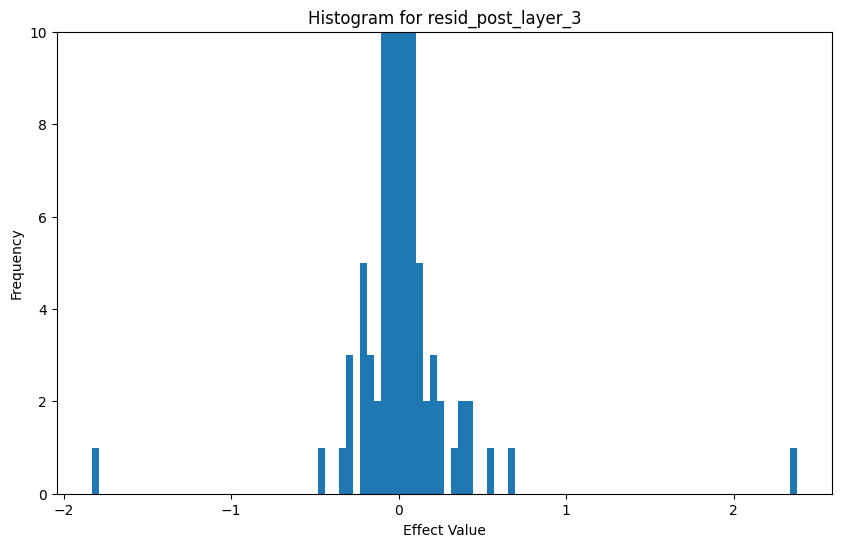

In [9]:
for i, ae_path in enumerate(ae_paths):
    node_effects_filename = f"{ae_path}/node_effects.pkl"

    with open(node_effects_filename, "rb") as f:
        node_effects = pickle.load(f)

    print(node_effects.keys())
    print(node_effects[-2].keys())

    effects = node_effects[-4][ae_path]
    print(effects.shape)

    # Create histogram
    plt.figure(figsize=(10, 6))
    plt.hist(effects, bins=100)
    plt.ylim(0, 10)
    plt.title(f'Histogram for {ae_path.split("/")[-3]}')
    plt.xlabel("Effect Value")
    plt.ylabel("Frequency")

    # Display the plot
    plt.show()

In [10]:
# def examine_dimension(
#     model,
#     submodule,
#     buffer,
#     feat_idx: int,
#     n_inputs: int,
#     context_length: int,
#     batch_size: int,
#     dictionary=None,
#     max_length: int = 128,
#     k: int = 30,
# ):


#     def _list_decode(x):
#         if isinstance(x, int):
#             return model.tokenizer.decode(x)
#         else:
#             return [_list_decode(y) for y in x]

#     # if dim_indices is None:
#         # dim_indices = random.randint(0, activations.shape[-1] - 1)

#     assert n_inputs % batch_size == 0
#     n_iters = n_inputs // batch_size

#     device = model.device

#     activations = torch.zeros((n_inputs, context_length), device=device)
#     tokens = torch.zeros((n_inputs, context_length), dtype=torch.long, device=device)

#     for i in tqdm(range(n_iters), desc="Collecting activations"):
#         inputs_BL = buffer.tokenized_batch(batch_size=batch_size)

#         with torch.no_grad(), model.trace(inputs_BL, **tracer_kwargs):
#             tokens_BL = model.input[1][
#                 "input_ids"
#             ].save()  # if you're getting errors, check here; might only work for pythia models
#             activations_BLD = submodule.output
#             if type(activations_BLD.shape) == tuple:
#                 activations_BLD = activations_BLD[0]
#             if dictionary is not None:
#                 activations_BLF = dictionary.encode(activations_BLD)
#             activations_BL = activations_BLF[:, :, feat_idx].save()

#         activations[i * batch_size : (i + 1) * batch_size] = activations_BL.value
#         tokens[i * batch_size : (i + 1) * batch_size] = tokens_BL.value

#     token_mean_acts = {}
#     for ctx in tokens:
#         for tok in ctx:
#             if tok.item() in token_mean_acts:
#                 continue
#             idxs = (tokens == tok).nonzero(as_tuple=True)
#             token_mean_acts[tok.item()] = activations[idxs].mean().item()
#     top_tokens = sorted(token_mean_acts.items(), key=lambda x: x[1], reverse=True)[:k]
#     top_tokens = [(model.tokenizer.decode(tok), act) for tok, act in top_tokens]

#     flattened_acts = einops.rearrange(activations, "b n -> (b n)")
#     topk_indices = torch.argsort(flattened_acts, dim=0, descending=True)[:k]
#     batch_indices = topk_indices // activations.shape[1]
#     token_indices = topk_indices % activations.shape[1]
#     tokens = [
#         tokens[batch_idx, : token_idx + 1].tolist()
#         for batch_idx, token_idx in zip(batch_indices, token_indices)
#     ]
#     activations = [
#         activations[batch_idx, : token_id + 1, None, None]
#         for batch_idx, token_id in zip(batch_indices, token_indices)
#     ]
#     decoded_tokens = _list_decode(tokens)
#     top_contexts = text_neuron_activations(decoded_tokens, activations)

#     top_affected = interp.feature_effect(
#         model, submodule, dictionary, feat_idx, tokens, max_length=max_length, k=k
#     )
#     top_affected = [(model.tokenizer.decode(tok), prob.item()) for tok, prob in zip(*top_affected)]

#     return namedtuple("featureProfile", ["top_contexts", "top_tokens", "top_affected"])(
#         top_contexts, top_tokens, top_affected
#     )

# # DEVICE = "cuda"
# # model_name = "EleutherAI/pythia-70m-deduped"
# # model = LanguageModel(model_name, device_map=DEVICE, dispatch=True)

# # ae_path = ae_paths[2]
# # submodule, dictionary, config = utils.load_dictionary(model, ae_path, DEVICE)

# # context_length = config['buffer']['ctx_len']

# # data = hf_dataset_to_generator("monology/pile-uncopyrighted")
# # buffer = ActivationBuffer(
# #     data,
# #     model,
# #     submodule,
# #     d_submodule=512,
# #     ctx_len=context_length,
# #     refresh_batch_size=128, # decrease to fit on smaller GPUs
# #     n_ctxs=512, # decrease to fit on smaller GPUs
# #     device=DEVICE
# # )

# feat_idx = 0
# sae_feat_idx = top_k_indices[feat_idx].item()
# print(sae_feat_idx)

# n_inputs = 1024
# batch_size = 256

# torch.cuda.empty_cache()
# torch.set_grad_enabled(False)

# out = examine_dimension(
#     model,
#     submodule,
#     buffer,
#     sae_feat_idx,
#     n_inputs,
#     context_length,
#     batch_size,
#     dictionary,
#     max_length=context_length,
#     k=30,
# )

# print(f'\n\ntop activating tokens for feature {sae_feat_idx}')
# for token in out.top_tokens:
#     print(token)
# print(f'\n\ntop affected tokens for feature {sae_feat_idx}')
# for token in out.top_affected:
#     print(token)

# out.top_contexts

In [11]:
def get_max_activating_prompts_old(
    model,
    submodule,
    inputs_bL: list[str],
    dim_indices: torch.Tensor,
    batch_size: int,
    dictionary=None,
    n_inputs: int = 512,
    k: int = 30,
):

    assert n_inputs % batch_size == 0
    n_iters = n_inputs // batch_size

    dim_count = dim_indices.shape[0]

    device = model.device

    max_activating_indices_FK = torch.zeros((dim_count, k), device=device, dtype=torch.int)
    max_activations_FK = torch.zeros((dim_count, k), device=device, dtype=torch.float32)

    for i in range(n_iters):

        batch_offset = i * batch_size

        inputs_BL = inputs_bL[batch_offset : batch_offset + batch_size]

        with torch.no_grad(), model.trace(inputs_BL, **tracer_kwargs):
            activations_BLD = submodule.output
            if type(activations_BLD.shape) == tuple:
                activations_BLD = activations_BLD[0]
            activations_BLF = dictionary.encode(activations_BLD)
            activations_BLF = activations_BLF[:, :, dim_indices].save()

        # Use einops to find the max activation per input
        activations_FB = einops.reduce(activations_BLF.value, 'B L F _> F B', 'max')
        
        # Keep track of input indices
        indices_B = torch.arange(batch_offset, batch_offset + batch_size, device=device)
        indices_FB = einops.repeat(indices_B, 'B -> F B', F=dim_count)

        # Concatenate current batch activations and indices with the previous ones
        combined_activations_FK = torch.cat([max_activations_FK, activations_FB], dim=1)
        combined_indices_FK = torch.cat([max_activating_indices_FK, indices_FB], dim=1)

        # Sort and keep top k activations for each dimension
        topk_activations_FK, topk_indices = torch.topk(combined_activations_FK, k, dim=1)
        max_activations_FK = topk_activations_FK
        max_activating_indices_FK = torch.gather(combined_indices_FK, 1, topk_indices)

    return max_activating_indices_FK, max_activations_FK


